

```
# This is formatted as code
```

# Polynomial Interpolation for cutting lines
I have collected pointclouds of retracted tissues attached to a flat surface at a point. Each tissue intersects with the flat surface along an arbitrary curved line, and my goal is to generate a smooth curve that interpolates points on that line via various polynomial interpolation methods. I envision that a robot can trace the interpolation curve (trajectory) with an electrocautery tool to cut and remove the attachment(s).

Apart from using libraries, I have implemented cubic spline interpolation in cubic_spline.py

## author: Shing Hei Ho

In [95]:
%load_ext autoreload
%autoreload 2

In [96]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import os
import pickle
import sys

In [97]:
# mount the dataset (the drive)
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [121]:
# set teh data directory location
DATA_DIREC = "/content/drive/MyDrive/cutline_splines_numerical/data/"
sys.path.append(DATA_DIREC)
code_path = "/content/drive/MyDrive/cutline_splines_numerical/"
sys.path.append(code_path)
from cubic_spline import *
from interp_poly import *

In [122]:
def plot_2D_points(xs, ys_list, title, x_label, y_label):
    fig, ax = plt.subplots()
    for idx in range(len(ys_list)):
        ax.scatter(xs, ys_list[idx], s=8)
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()

In [123]:
def plot_3D_points(xs, ys, zs, title):
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    ax.scatter(xs, ys, zs, c=[0,0,1], s=8)
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(azim=45, elev=30)
    plt.show()

# For each retracted tissue, get 3D partial-view point clouds, get the points at the bottom of the retracted tissue and plot their xy coordinates

<ipython-input-123-6ac84deb4c4c>:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xs, ys, zs, c=[0,0,1], s=8)


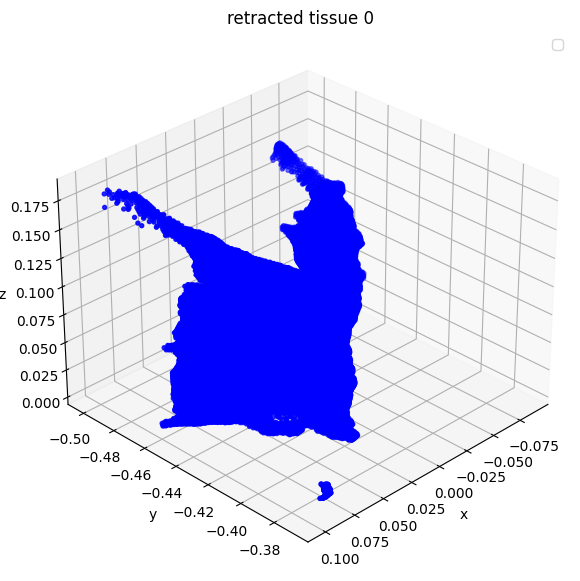

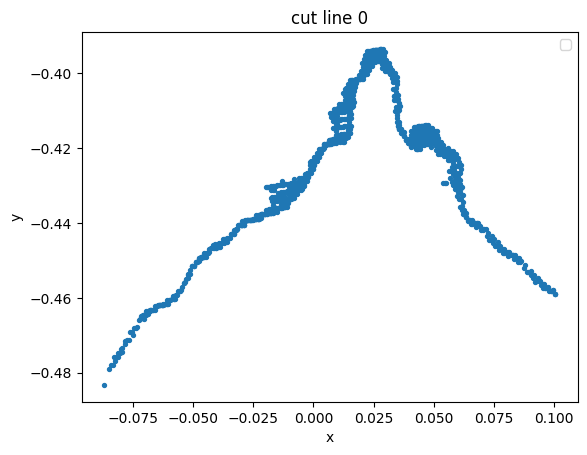

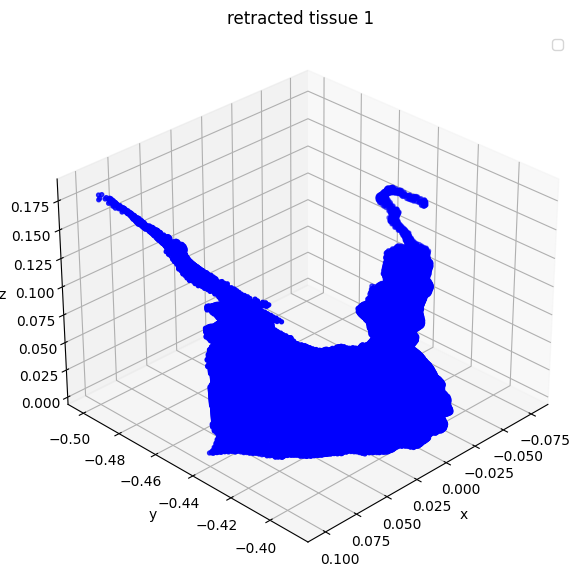

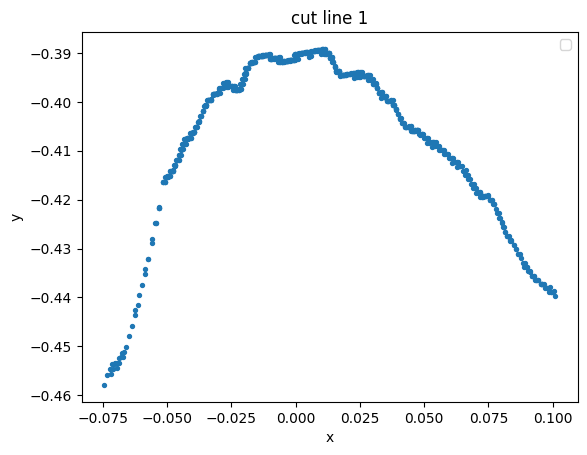

In [124]:
pc_paths = [os.path.join(DATA_DIREC, "data_2.pickle"), os.path.join(DATA_DIREC, "data_7.pickle")]
pcs = []
for pc_path in pc_paths:
  with open(pc_path, 'rb') as handle:
      data = pickle.load(handle)
  pc = np.array(data["pc"])[:,:3]
  pcs.append(pc)

pcs_filtered = []
for i in range(len(pcs)):
  pc = pcs[i]
  max_z = 0.008
  max_y = -0.379
  maskz = pc[:,2]<=max_z
  masky = pc[:,1]<=max_y
  mask = maskz & masky
  idx = np.nonzero(mask)[0]
  pc_filtered = pc[idx,:]
  pcs_filtered.append(pc_filtered)

  xs = pc_filtered[:,0]
  ys = pc_filtered[:,1]

  plot_3D_points(pc[:,0], pc[:,1], pc[:,2], title=f"retracted tissue {i}")
  plot_2D_points(xs, ys_list=[ys], title=f"cut line {i}", x_label="x", y_label="y")


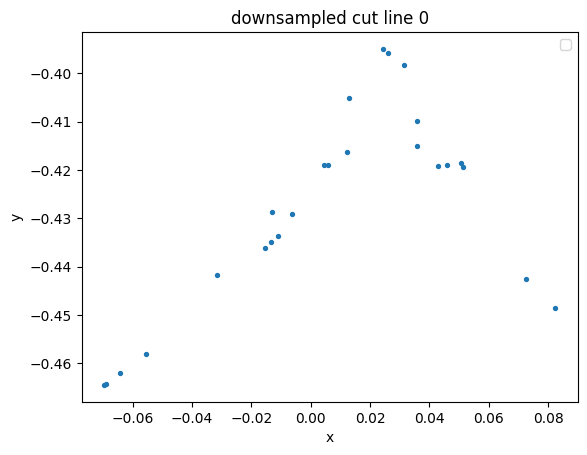

0--- num pts after downsample and remove duplicate:  25


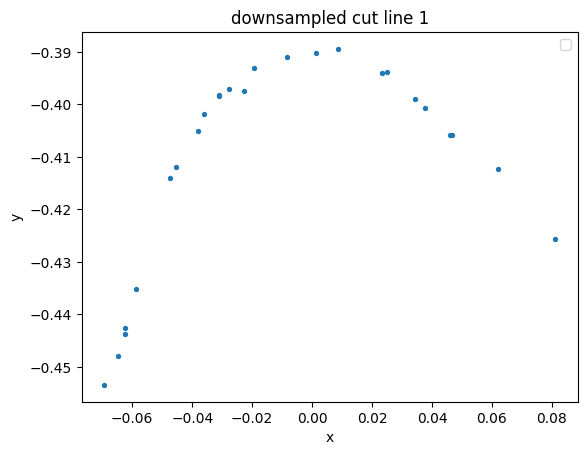

1--- num pts after downsample and remove duplicate:  25


In [143]:
# randomly sample points on each cut line for interpolation later
##### tune the number of interp points
num_interp_pts = 25
np.random.seed(2021)
pcs_downsampled = []
for i, pc_filtered in enumerate(pcs_filtered):
  rand_idxs = np.random.randint(low=0, high=len(pc_filtered), size=(num_interp_pts,))
  pc_downsampled = pc_filtered[rand_idxs,:]
  _,unique_idx = np.unique(pc_downsampled[:,1], return_index=True)
  pc_downsampled = pc_downsampled[unique_idx,:]
  pcs_downsampled.append(pc_downsampled)
  xs = pc_downsampled[:,0]
  ys = pc_downsampled[:,1]
  plot_2D_points(xs, ys_list=[ys], title=f"downsampled cut line {i}", x_label="x", y_label="y")
  print(f"{i}--- num pts after downsample and remove duplicate: ", len(pc_downsampled))



# cut line 0 (Hard case)

In [144]:
pc_downsampled = pcs_downsampled[0]
xi = pc_downsampled[:,0].astype(float)
yi = pc_downsampled[:,1].astype(float)
sorted_x_idx = np.argsort(xi)
xi = xi[sorted_x_idx]
yi = yi[sorted_x_idx]

x_min = xi.min()
x_max = xi.max()
num_test_pts = 100
x_test = np.linspace(x_min, x_max, num_test_pts)

num nodes:  25
evaluating interp node 0
evaluating interp node 10
evaluating interp node 20
evaluating interp node 30
evaluating interp node 40
evaluating interp node 50
evaluating interp node 60
evaluating interp node 70
evaluating interp node 80
evaluating interp node 90


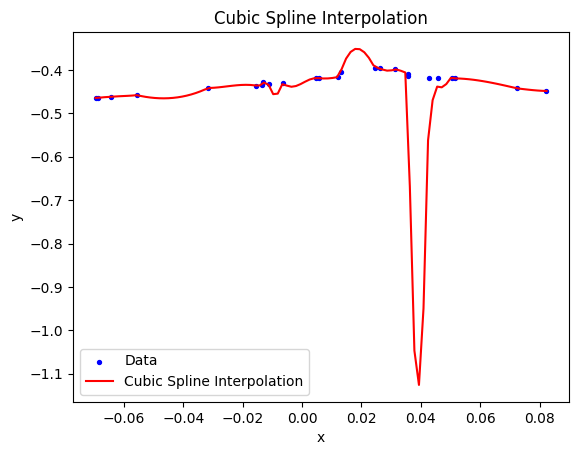

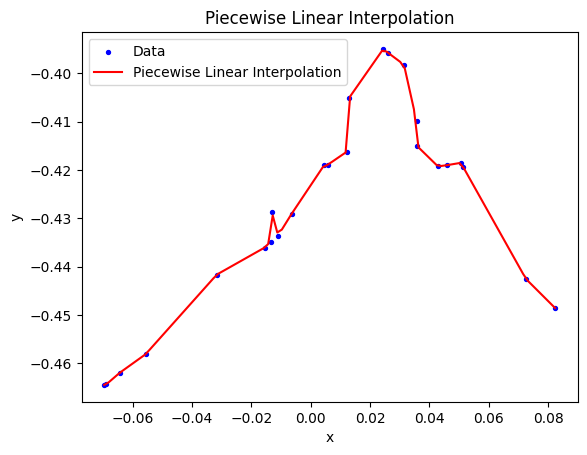

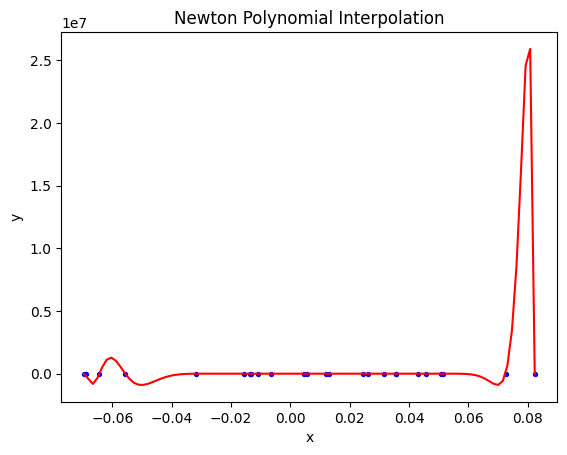

In [145]:
######################### Cubic Spline Interpolation ########################

ai,bi,ci,di = cubic_spline(xi, yi)
y_test =  eval_cubic_spline(xi,ai,bi,ci,di,x_test)

plt.scatter(xi,yi, label='Data', color='blue', s=8)
plt.plot(x_test, y_test, label='Cubic Spline Interpolation', color='red')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Cubic Spline Interpolation')

plt.legend()
plt.show()

################# Piecewise Linear interpolation ##########################
xint = np.linspace(x_min, x_max, 300)
y_test = np.interp(x_test, xi, yi)

plt.scatter(xi, yi, label='Data', color='blue', s=8)
plt.plot(x_test, y_test, label='Piecewise Linear Interpolation', color='red')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Piecewise Linear Interpolation')

plt.legend()
plt.show()

############### Newton polynomial interpolation #############

c = newton_interp_poly(xi, yi)

y_test = []
for x in x_test:
  y =  eval_newton_interp_poly(c,xi,x)
  y_test.append(y)
ys = np.array(ys)

plt.scatter(xi, yi, label='Data', color='blue', s=8)
plt.plot(x_test, y_test, label='Newton Poly Interpolation', color='red')

plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Newton Polynomial Interpolation')

plt.show()


# cut line 1 (Easy case)

In [147]:
pc_downsampled = pcs_downsampled[1]
xi = pc_downsampled[:,0]
yi = pc_downsampled[:,1]
sorted_x_idx = np.argsort(xi)
xi = xi[sorted_x_idx]
yi = yi[sorted_x_idx]

x_min = xi.min()
x_max = xi.max()
num_test_pts = 100
x_test = np.linspace(x_min, x_max, num_test_pts)

num nodes:  25
evaluating interp node 0
evaluating interp node 10
evaluating interp node 20
evaluating interp node 30
evaluating interp node 40
evaluating interp node 50
evaluating interp node 60
evaluating interp node 70
evaluating interp node 80
evaluating interp node 90


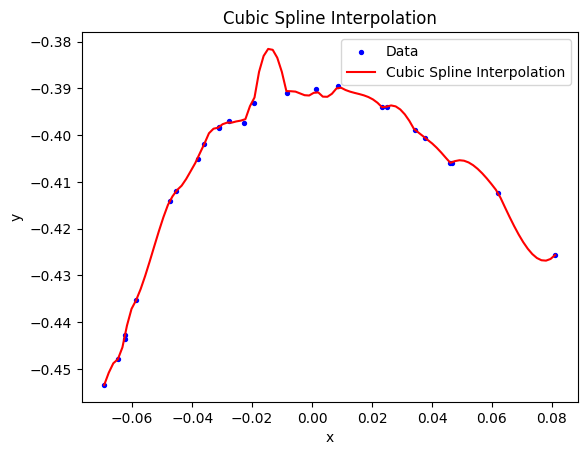

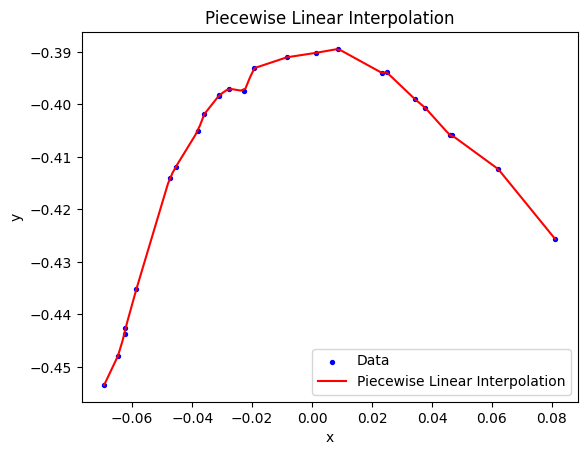

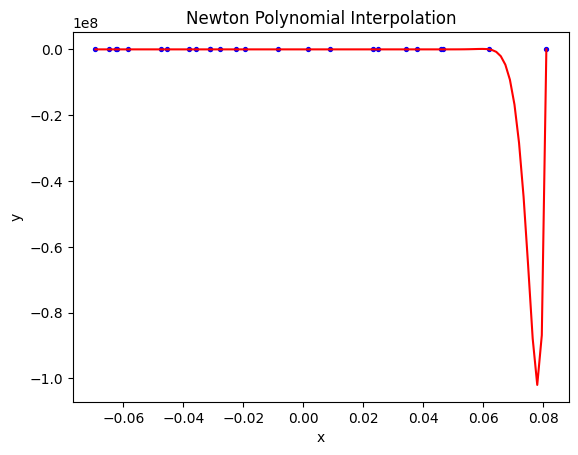

In [148]:
######################### Cubic Spline Interpolation ########################

ai,bi,ci,di = cubic_spline(xi, yi)
y_test =  eval_cubic_spline(xi,ai,bi,ci,di,x_test)

plt.scatter(xi,yi, label='Data', color='blue', s=8)
plt.plot(x_test, y_test, label='Cubic Spline Interpolation', color='red')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Cubic Spline Interpolation')

plt.legend()
plt.show()

################# Piecewise Linear interpolation ##########################
xint = np.linspace(x_min, x_max, 300)
y_test = np.interp(x_test, xi, yi)

plt.scatter(xi, yi, label='Data', color='blue',s=8)
plt.plot(x_test, y_test, label='Piecewise Linear Interpolation', color='red')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Piecewise Linear Interpolation')

plt.legend()
plt.show()

############### degree 6 polynomial interpolation #############

c = newton_interp_poly(xi, yi)

y_test = []
for x in x_test:
  y =  eval_newton_interp_poly(c,xi,x)
  y_test.append(y)
ys = np.array(ys)

plt.scatter(xi, yi, label='Data', color='blue',s=8)
plt.plot(x_test, y_test, label='Newton Poly Interpolation', color='red')

plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Newton Polynomial Interpolation')

plt.show()